In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, make_moons, load_breast_cancer, load_digits
from sklearn.decomposition import PCA

import numpy as np
from cvxopt import matrix, solvers

## 🧩 KKT Derivation for Hard-Margin SVM

We derive the KKT conditions for the hard-margin Support Vector Machine (SVM) starting from its primal form.

---


### ✅ Step 1: Primal Optimization Problem

We begin with the primal formulation of the hard-margin SVM:

$$
\begin{aligned}
\min_{\mathbf{w}, b} \quad & \frac{1}{2} \|\mathbf{w}\|^2 \\
\text{subject to:} \quad & y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1, \quad \forall i
\end{aligned}
$$

This is a convex quadratic optimization problem with inequality constraints.




The functional margin $y_i(\mathbf{w}^\top \mathbf{x}_i + b)$ can be arbitrarily scaled by rescaling $\mathbf{w}$ and $b$. To remove this ambiguity, we fix the functional margin of the closest point(s) to 1.

This normalization allows the optimization to focus on the **direction** of the hyperplane rather than its scale.

Minimizing $\|\mathbf{w}\|^2$ corresponds to **maximizing the geometric margin**, since the margin is inversely proportional to $\|\mathbf{w}\|$. The objective $\frac{1}{2} \|\mathbf{w}\|^2$ serves as a smooth and convex proxy for maximizing class separation.

### ✅ Step 2: Form the Lagrangian

We introduce Lagrange multipliers $ \alpha_i \geq 0 $ for the constraints and define the Lagrangian:

$$
\mathcal{L}(\mathbf{w}, b, \boldsymbol{\alpha}) = \frac{1}{2} \|\mathbf{w}\|^2 - \sum_{i=1}^N \alpha_i \left( y_i (\mathbf{w}^\top \mathbf{x}_i + b) - 1 \right)
$$


### ✅ Step 3: KKT Conditions

The Karush-Kuhn-Tucker (KKT) conditions are necessary (and sufficient for convex problems) for optimality.

#### 1. **Stationarity**:
Take derivatives of the Lagrangian and set them to zero:

- With respect to $ \mathbf{w} $:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = \mathbf{w} - \sum_{i=1}^N \alpha_i y_i \mathbf{x}_i = 0
\quad \Rightarrow \quad
\boxed{\mathbf{w} = \sum_{i=1}^N \alpha_i y_i \mathbf{x}_i}
$$

- With respect to $ b $:

$$
\frac{\partial \mathcal{L}}{\partial b} = -\sum_{i=1}^N \alpha_i y_i = 0
\quad \Rightarrow \quad
\boxed{\sum_{i=1}^N \alpha_i y_i = 0}
$$

---

#### 2. **Primal Feasibility**:
The original constraints must hold:

$$
y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1
$$

---

#### 3. **Dual Feasibility**:
Lagrange multipliers must be non-negative:

$$
\boxed{\alpha_i \geq 0}
$$

---

#### 4. **Complementary Slackness**:
Each $ \alpha_i $ and its corresponding constraint satisfy:

$$
\boxed{\alpha_i \cdot (y_i(\mathbf{w}^\top \mathbf{x}_i + b) - 1) = 0}
$$

This implies:

- If $ \alpha_i > 0 $, then $ y_i(\mathbf{w}^\top \mathbf{x}_i + b) = 1  $ (point lies on the margin)
- If $  y_i(\mathbf{w}^\top \mathbf{x}_i + b) > 1 $, then $ \alpha_i = 0  $ (point is not a support vector)

---

### ✅ Summary of KKT Conditions

- $ \mathbf{w} = \sum_i \alpha_i y_i \mathbf{x}_i $
- $ \sum_i \alpha_i y_i = 0 $
- $ y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1 $
- $ \alpha_i \geq 0 $
- $ \alpha_i \left[ y_i(\mathbf{w}^\top \mathbf{x}_i + b) - 1 \right] = 0 $

These conditions fully characterize the solution to the hard-margin SVM problem.

In [110]:
def hard_svm(X: np.ndarray, y: np.ndarray, target: int):
    """
    Trains a hard-margin binary SVM using quadratic programming for one-vs-rest classification.

    Args:
        X (np.ndarray): Feature matrix of shape (n_samples, n_features)
        y (np.ndarray): Original class labels of shape (n_samples,)
        target (int): The positive class label to separate (binary: target vs rest)

    Returns:
        w (np.ndarray): Weight vector of the hyperplane
        b (float): Bias term
    """
    n_samples = X.shape[0]

    # Convert labels to +1 / -1
    y_bin = np.where(y == target, 1, -1).astype(np.float64)
    # Compute the Gram matrix
    K = X @ X.T  # shape: (n_samples, n_samples)

    # Quadratic programming matrices
    P = matrix(np.outer(y_bin, y_bin) * K)
    q = matrix(-np.ones(n_samples))

    G = matrix(-np.eye(n_samples))  # alpha_i >= 0
    h = matrix(np.zeros(n_samples))

    A = matrix(y_bin.reshape(1, -1))
    b = matrix(np.zeros(1))

    # Suppress solver output
    solvers.options["show_progress"] = False
    solution = solvers.qp(P, q, G, h, A, b)

    # Extract solution
    alphas = np.array(solution["x"]).flatten()

    epsilon = 1e-6
    support_mask = alphas > epsilon

    # Support vectors
    sup_X = X[support_mask]
    sup_y = y_bin[support_mask]
    sup_alphas = alphas[support_mask]

    # Compute weight vector
    w = np.sum(sup_alphas[:, None] * sup_y[:, None] * sup_X, axis=0)

    # Compute bias using support vectors
    b = np.mean(sup_y - sup_X @ w)

    return w, b, support_mask

In [73]:
X, y = load_iris(return_X_y=True)
# X = X[y!=1]
# y = y[y!=1]
# X, y = load_digits(return_X_y=True)

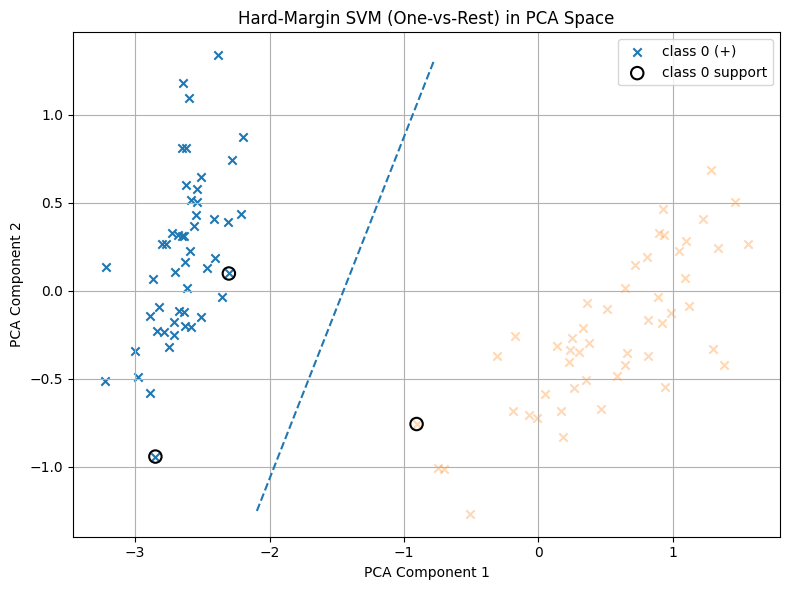

In [114]:

# Fit PCA and reduce X to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# target_pairs = [(0, 2), (0, 1)]
target_pairs = [(0, 2)]
plt.figure(figsize=(8, 6))
for i, target_pair in enumerate(target_pairs):

    target, remove = target_pair
    _X = X[y!=remove]
    _y = y[y!=remove]
    _X_2d = X_2d[y!=remove]

    # Train SVM for this class vs rest
    w, b, support_mask = hard_svm(_X, _y, target)
    
    # Project weight vector into PCA space
    w_proj = pca.components_ @ w  # shape: (2,)
    
    # Compute decision scores in original space
    decisions = _X @ w + b
    positive = decisions > 0

    # Plot predicted positives and negatives
    plt.scatter(_X_2d[positive, 0], _X_2d[positive, 1], marker='x', label=f'class {target} (+)')
    plt.scatter(_X_2d[~positive, 0], _X_2d[~positive, 1], marker='x', alpha=0.3)

    # Plot support vectors
    plt.scatter(_X_2d[support_mask, 0], _X_2d[support_mask, 1], edgecolors='k',
                facecolors='none', s=80, linewidths=1.5, label=f'class {target} support')

    # Plot decision boundary in PCA space
    x_vals = np.linspace(_X_2d[:, 0].min(), _X_2d[:, 0].max(), 200)
    if w_proj[1] != 0:  # avoid division by zero

        # b = (_X_2d[support_mask] @ w_proj).mean()
        # y_vals = -(w_proj[0] * x_vals - b) / w_proj[1]
        y_vals = -(w_proj[0] * x_vals + b * w_proj[0]) / w_proj[1]
        # Clip line to visible region
        y_mask = (y_vals > _X_2d[:, 1].min()) & (y_vals < _X_2d[:, 1].max())
        plt.plot(x_vals[y_mask], y_vals[y_mask], '--')
        # plt.plot(x_vals, y_vals, '--', label=f'class {target} boundary')

plt.title("Hard-Margin SVM (One-vs-Rest) in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [87]:
b

0.002787033319473284